In [4]:
from func import *
with open('graph/multimodal_graph.gpickle', 'rb') as f:
    # Carregar o grafo do metro
    G_Multi = pickle.load(f)

In [5]:
# Definir data/hora e nós de origem/destino
start_datetime = datetime(2025, 12, 23, 8, 30, 0) # (ano, mês, dia, hora, minuto, segundo)

In [6]:
# Definir coordenadas de início e fim (Caso queira escolher pelo mapa, https://geojson.io/#map=9.43/40.9863/-8.3466)
START_COORDS = (41.18908067200954, -8.706121515136346)# START_COORDS = (41.1584, -8.6291)  # Cordenadas do ponto de início: (Latitude, Longitude)
END_COORDS   = (41.120878300205845, -8.593518284626981)# END_COORDS   = (41.1404, -8.6118)  # Cordenadas do ponto de fim: (Latitude, Longitude)

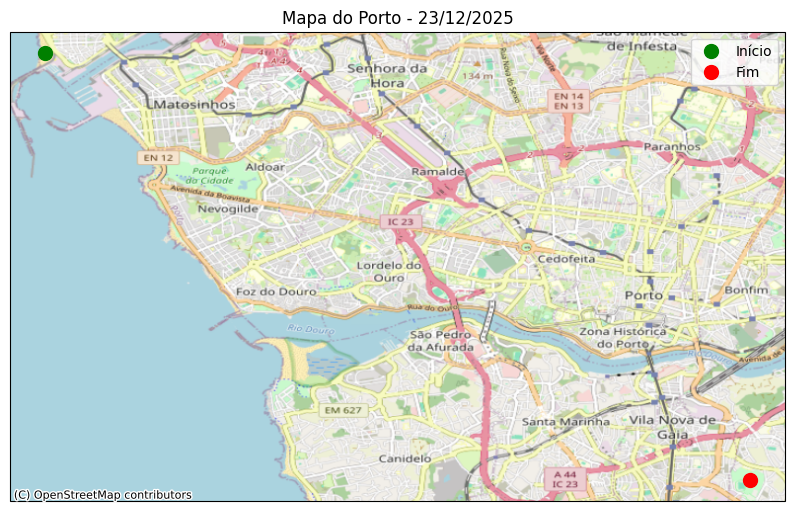

In [7]:
# Visualizar os pontos no mapa usando Cartopy e Contextily
fig = plt.figure(figsize=(10, 10))

# Definir a projeção do gráfico como PlateCarree
ax = plt.axes(projection=ccrs.PlateCarree())

# Marcar Ponto de Início (Verde)
ax.scatter(START_COORDS[1], START_COORDS[0], color='green', s=100, 
           transform=ccrs.PlateCarree(), label='Início', zorder=5)

# Marcar Ponto de Fim (Vermelho)
ax.scatter(END_COORDS[1], END_COORDS[0], color='red', s=100, 
           transform=ccrs.PlateCarree(), label='Fim', zorder=5)

# Adicionar Legenda
ax.legend(loc='upper right')
ax.set_title(f"Mapa do Porto - {start_datetime.strftime('%d/%m/%Y')}")

# Adicionar Basemap
ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.OpenStreetMap.Mapnik)

plt.show()


Executando NSGA-III com 101 indivíduos por 50 gerações...
Gerando 101 caminhos iniciais com pesos variados...
Inicialização concluída. 1 caminhos únicos gerados.
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      101 |      1 |             - |             -
     2 |      202 |      9 |  1.0000000000 |         ideal
     3 |      303 |     15 |  0.0135101896 |         ideal
     4 |      404 |     13 |  0.0021765654 |             f
     5 |      505 |     14 |  0.0076498625 |         nadir
     6 |      606 |     19 |  0.0216874334 |             f
     7 |      707 |     21 |  0.0045331208 |             f
     8 |      808 |     23 |  0.0052202766 |             f
     9 |      909 |     25 |  0.0049750676 |             f
    10 |     1010 |     27 |  0.0029754422 |             f
    11 |     1111 |     28 |  0.0023831303 |             f
    12 |     1212 |     29 |  0.0050042271 |             f
    13 |     1313 |     30 |  0.0031833712 |             f
    14 |    

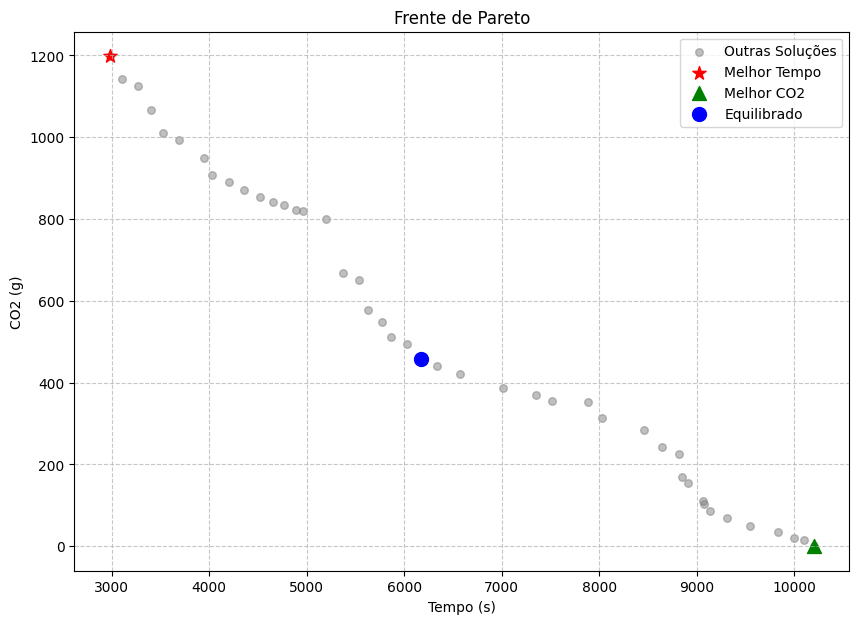

--------------------------------------------------
1. Melhor Tempo: 2978s | CO2: 1198.18g
2. Equilibrado : 6169s | CO2: 457.11g
3. Melhor CO2  : 10203s | CO2: 0.00g
--------------------------------------------------


In [8]:
# Configuração e execução do NSGA-III
source_node = NearestGraphNode(G_Multi, START_COORDS)
target_node = NearestGraphNode(G_Multi, END_COORDS)

ref_dirs = get_reference_directions("das-dennis", 2, n_partitions=100) # Gerar direções de referência para NSGA-III
sampling = GraphSampling(G_Multi, source_node, target_node, start_datetime) # Amostragem inicial baseada em caminhos do grafo
crossover = PathCrossover(prob=0.8)
mutation = PathMutation(G_Multi, prob=0.3)

algorithm = NSGA3(
    pop_size=len(ref_dirs),
    ref_dirs=ref_dirs,
    sampling=sampling,
    crossover=crossover,
    mutation=mutation,
    eliminate_duplicates=False 
)

problem = RoutingProblem(G_Multi, source_node, target_node)

print(f"Executando NSGA-III com {len(ref_dirs)} indivíduos por 50 gerações...")

res = minimize(problem,
               algorithm,
               termination=('n_gen', 50), 
               seed=1,
               verbose=True)

print(f"Terminado. Soluções encontradas: {len(res.F)}")

F = res.F 
X = res.X 

# Analisar e Visualizar Resultados
idx_time = int(np.argmin(F[:, 0]))
idx_co2 = int(np.argmin(F[:, 1]))
sorted_indices = np.argsort(F[:, 0])
idx_balanced = int(sorted_indices[len(sorted_indices) // 2])

# Plotar a Frente de Pareto destacando os 3 pontos
plt.figure(figsize=(10, 7))
plt.scatter(F[:, 0], F[:, 1], c='gray', s=30, alpha=0.5, label='Outras Soluções')
plt.scatter(F[idx_time, 0], F[idx_time, 1], c='red', s=100, marker='*', label='Melhor Tempo')
plt.scatter(F[idx_co2, 0], F[idx_co2, 1], c='green', s=100, marker='^', label='Melhor CO2')
plt.scatter(F[idx_balanced, 0], F[idx_balanced, 1], c='blue', s=100, marker='o', label='Equilibrado')

plt.title("Frente de Pareto")
plt.xlabel("Tempo (s)")
plt.ylabel("CO2 (g)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# Imprimir detalhes
print("-" * 50)
print(f"1. Melhor Tempo: {F[idx_time, 0]:.0f}s | CO2: {F[idx_time, 1]:.2f}g")
print(f"2. Equilibrado : {F[idx_balanced, 0]:.0f}s | CO2: {F[idx_balanced, 1]:.2f}g")
print(f"3. Melhor CO2  : {F[idx_co2, 0]:.0f}s | CO2: {F[idx_co2, 1]:.2f}g")
print("-" * 50)

def a_extract_path(x):
    # x pode ser: lista de nós, ndarray de objeto com shape (1,), ou escalar
    if isinstance(x, np.ndarray):
        if x.ndim == 0:
            x = x.item()
        elif x.ndim == 1 and x.size == 1:
            x = x[0]
    # Se for escalar inteiro, embrulhar em lista para evitar erros de indexação
    if isinstance(x, (int, np.integer)):
        x = [int(x)]
    return x


 Rota com melhor tempo:

📍 DETALHES DO ITINERÁRIO
🚶 Caminhar
   De:   10221872818
   Até:  9004879460
   Dura: 21.7s | CO2: 0.00g
   ---
🚶 Caminhar
   De:   9004879460
   Até:  B-PLE1
   Dura: 13.9s | CO2: 0.00g
   ---
🚌 Apanhar Autocarro 
   De:   B-PLE1
   Até:  B-SDP1
   Dura: 673.0s | CO2: 968.83g
   ---
🚶 Caminhar
   De:   B-SDP1
   Até:  112594210
   Dura: 11.0s | CO2: 0.00g
   ---
🚶 Caminhar
   De:   112594210
   Até:  2281040866
   Dura: 130.6s | CO2: 0.00g
   ---
🚶 Caminhar
   De:   2281040866
   Até:  T-5711
   Dura: 25.9s | CO2: 0.00g
   ---
🚶 Caminhar
   De:   T-5711
   Até:  T-5774
   Dura: 780.0s | CO2: 229.35g
   ---
🚶 Caminhar
   De:   T-5774
   Até:  11397043889
   Dura: 9.8s | CO2: 0.00g
   ---
🚶 Caminhar
   De:   11397043889
   Até:  1132446640
   Dura: 1312.2s | CO2: 0.00g
   ---



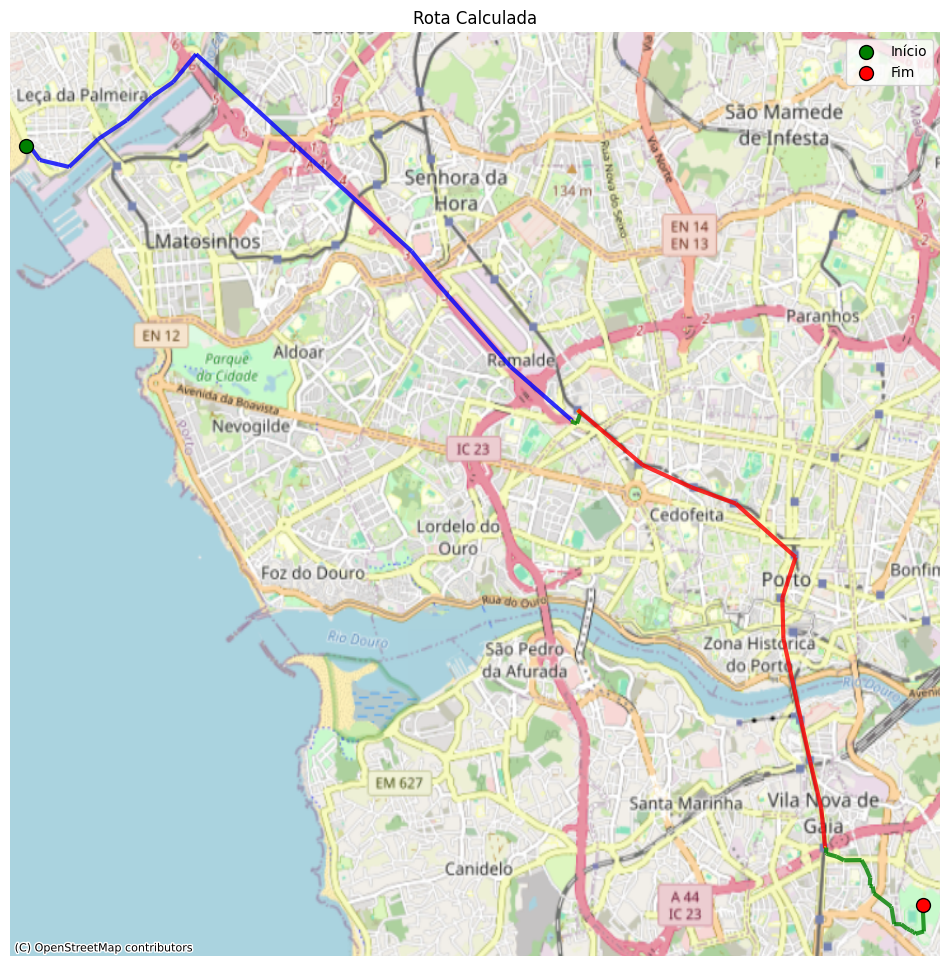

In [9]:
print("\n Rota com melhor tempo:")
path_time = a_extract_path(X[idx_time])
print_detailed_itinerary(G_Multi, path_time) 
PlotPath(G_Multi, path_time)


 Rota mais ecologica (CO2):

📍 DETALHES DO ITINERÁRIO
🚶 Caminhar
   De:   10221872818
   Até:  1132446640
   Dura: 10203.3s | CO2: 0.00g
   ---



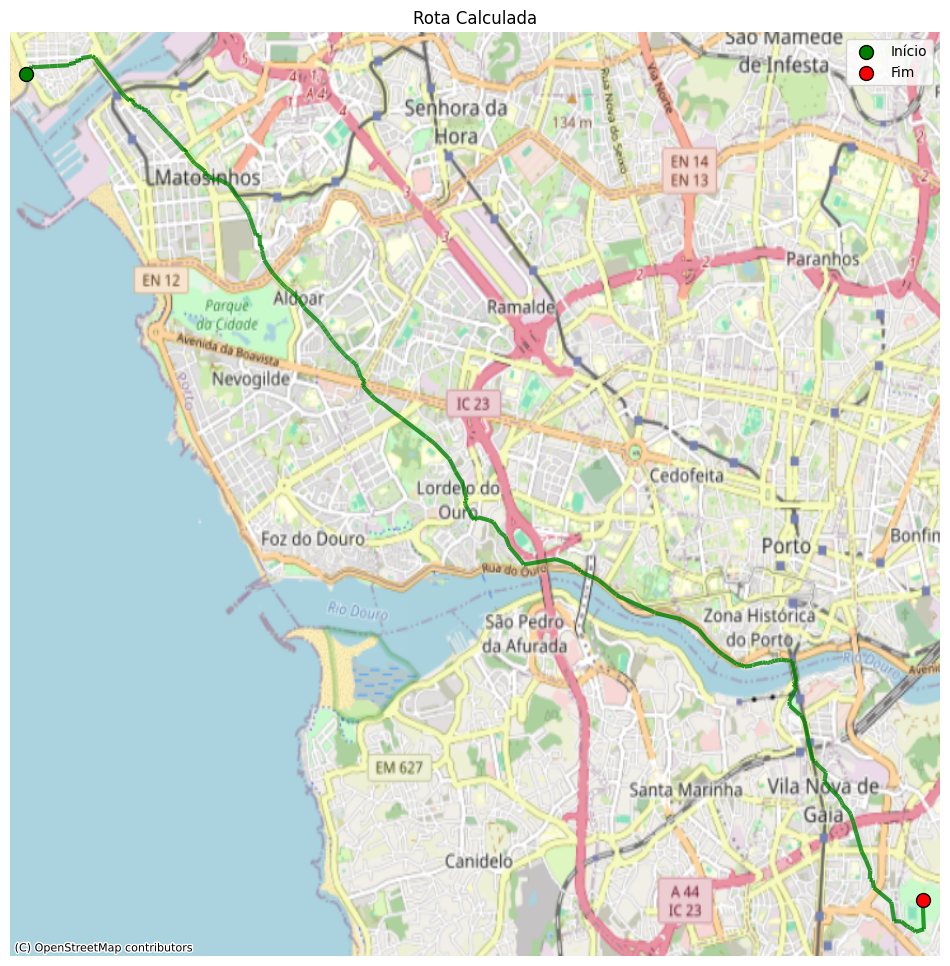

In [10]:
print("\n Rota mais ecologica (CO2):")
path_co2 = a_extract_path(X[idx_co2])
print_detailed_itinerary(G_Multi, path_co2) 
PlotPath(G_Multi, path_co2)


 Rota equilibrada:

📍 DETALHES DO ITINERÁRIO
🚶 Caminhar
   De:   10221872818
   Até:  1236467461
   Dura: 3701.6s | CO2: 0.00g
   ---
🚶 Caminhar
   De:   1236467461
   Até:  B-RAEP1
   Dura: 17.9s | CO2: 0.00g
   ---
🚌 Apanhar Autocarro 
   De:   B-RAEP1
   Até:  B-SDP1
   Dura: 180.0s | CO2: 227.76g
   ---
🚶 Caminhar
   De:   B-SDP1
   Até:  112594210
   Dura: 11.0s | CO2: 0.00g
   ---
🚶 Caminhar
   De:   112594210
   Até:  2281040866
   Dura: 130.6s | CO2: 0.00g
   ---
🚶 Caminhar
   De:   2281040866
   Até:  T-5711
   Dura: 25.9s | CO2: 0.00g
   ---
🚶 Caminhar
   De:   T-5711
   Até:  T-5774
   Dura: 780.0s | CO2: 229.35g
   ---
🚶 Caminhar
   De:   T-5774
   Até:  11397043889
   Dura: 9.8s | CO2: 0.00g
   ---
🚶 Caminhar
   De:   11397043889
   Até:  1132446640
   Dura: 1312.2s | CO2: 0.00g
   ---



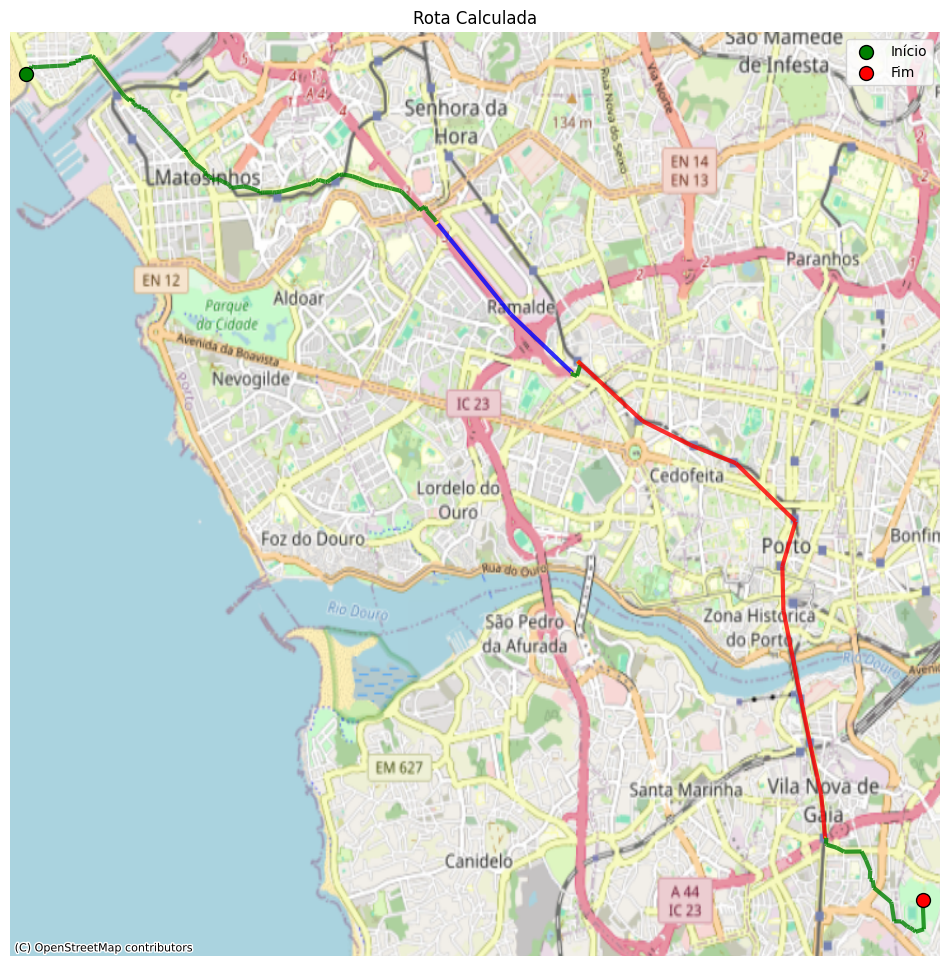

In [11]:
print("\n Rota equilibrada:")
path_balanced = a_extract_path(X[idx_balanced])
print_detailed_itinerary(G_Multi, path_balanced) 
PlotPath(G_Multi, path_balanced)


In [12]:
# Pós entrega

In [23]:
from func import *
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.optimize import minimize
from pymoo.operators.crossover.ox import OrderCrossover 
from pymoo.operators.mutation.inversion import InversionMutation 
from pymoo.core.duplicate import ElementwiseDuplicateElimination

# 1. Funções e Classes Auxiliares

# Corverter um objeto datetime para segundos desde a meia-noite
def get_seconds_from_midnight(dt):
    return dt.hour * 3600 + dt.minute * 60 + dt.second

# Versão Dinâmica do InitMOEAD, que consulta horários GTFS
def DynamicInitMOEAD(G, source, target, start_datetime, active_bus_ids, active_transit_ids, pop_size=10):
    print(f"🔄 A gerar {pop_size} caminhos iniciais DINÂMICOS (consultando horários)...")
    paths = []
    
    # Gerar vetores de peso (Trade-off Tempo vs CO2)
    weights = []
    if pop_size > 1:
        for i in range(pop_size):
            alpha = i / (pop_size - 1)
            weights.append((1 - alpha, alpha)) 
    else:
        weights.append((1.0, 0.0))

    target_coords = GetCoords(G, target)
    start_seconds = get_seconds_from_midnight(start_datetime)

    for w_time, w_co2 in weights:
        pq = []
        heapq.heappush(pq, (0, 0, start_seconds, source, [source]))
        
        visited = {} 
        path_found = None
        max_iter = 5000 
        iter_count = 0
        
        while pq and iter_count < max_iter:
            iter_count += 1
            f, g, curr_sec, u, path = heapq.heappop(pq)
            
            if u == target:
                path_found = path
                break
            
            if u in visited and visited[u] < g:
                continue
            visited[u] = g
            
            for v in G.neighbors(u):
                # Consulta dinâmica aos horários reais
                time_cost, co2_cost, valid = GetDynamicEdgeCost(
                    G, u, v, curr_sec, 
                    active_bus_ids, active_transit_ids, 
                    weight='time'
                )
                
                if not valid: continue
                
                step_cost = (w_time * time_cost) + (w_co2 * co2_cost)
                new_g = g + step_cost
                new_sec = curr_sec + time_cost 
                
                v_coords = GetCoords(G, v)
                h = MultiObjectiveHeuristic(v_coords, target_coords, w_time, w_co2)
                
                if v not in visited or new_g < visited[v]:
                     heapq.heappush(pq, (new_g + h, new_g, new_sec, v, path + [v]))
        
        if path_found:
            paths.append(path_found)
        else:
            try:
                paths.append(nx.shortest_path(G, source, target))
            except:
                pass

    unique_paths = []
    seen = set()
    for p in paths:
        t_p = tuple(p)
        if t_p not in seen:
            unique_paths.append(p)
            seen.add(t_p)
            
    print(f"✅ Inicialização Dinâmica concluída. {len(unique_paths)} caminhos únicos gerados.")
    return unique_paths

# Inicialização Dinâmica personalizada para pymoo com o DynamicInitMOEAD
class DynamicGraphSampling(Sampling):
    def __init__(self, G, start_node, end_node, start_datetime, active_bus, active_transit):
        super().__init__()
        self.G = G
        self.start_node = start_node
        self.end_node = end_node
        self.start_datetime = start_datetime
        self.active_bus = active_bus
        self.active_transit = active_transit

    def _do(self, problem, n_samples, **kwargs):
        initial_paths = DynamicInitMOEAD(
            self.G, self.start_node, self.end_node, self.start_datetime,
            self.active_bus, self.active_transit, pop_size=n_samples
        )
        if not initial_paths:
             try:
                initial_paths = [nx.shortest_path(self.G, self.start_node, self.end_node)]
             except:
                initial_paths = [[]] 
        while len(initial_paths) < n_samples:
            initial_paths.append(initial_paths[0]) 
        initial_paths = initial_paths[:n_samples]
        X = np.empty((n_samples, 1), dtype=object)
        for i in range(n_samples):
            X[i, 0] = initial_paths[i]
        return X

# Eliminação de duplicados personalizada para caminhos
class PathDuplicateElimination(ElementwiseDuplicateElimination):
    def is_equal(self, a, b):
        # Acedemos a .X[0] porque 'a' e 'b' são objetos Individual
        return a.X[0] == b.X[0]

# 2. Preparação do Problema
calendar = pd.read_csv('bus/calendar.txt')
calendar_dates = pd.read_csv('bus/calendar_dates.txt')
trips = pd.read_csv('bus/trips.txt')
calendar_metro = pd.read_csv('transit/calendar.txt')
calendar_dates_metro = pd.read_csv('transit/calendar_dates.txt')
trips_metro = pd.read_csv('transit/trips.txt')

# Converter coordenadas para nós
source_node = NearestGraphNode(G_Multi, START_COORDS)
target_node = NearestGraphNode(G_Multi, END_COORDS)
print(f"Origem: {source_node} | Destino: {target_node}")

# Instanciar o Problema
problem = RoutingProblem(G_Multi, source_node, target_node)

# Carregar serviços ativos
day_str = start_datetime.strftime("%Y%m%d")
print("A carregar serviços ativos...")

active_bus_df = GetActiveServices(day_str, calendar, calendar_dates, trips)
active_bus_ids = set(active_bus_df['trip_id'].values)

active_transit_df = GetActiveServices(day_str, calendar_metro, calendar_dates_metro, trips_metro)
active_transit_ids = set(active_transit_df['trip_id'].values)

# 3. Configuração e Execução do Algoritmo

ref_dirs = get_reference_directions("das-dennis", 2, n_partitions=100)

algorithm = NSGA3(
    pop_size=101, 
    ref_dirs=ref_dirs,
    sampling=DynamicGraphSampling(
        G_Multi, 
        source_node, 
        target_node, 
        start_datetime, 
        active_bus_ids, 
        active_transit_ids
    ),
    crossover=PathCrossover(prob=0.9),
    mutation=PathMutation(G_Multi, prob=0.3),
    eliminate_duplicates=PathDuplicateElimination() # <-- Agora deve funcionar
)

print("🚀 A iniciar Otimização Evolutiva com Consciência Temporal...")
res = minimize(
    problem,
    algorithm,
    ('n_gen', 50),
    seed=1,
    verbose=True
)
print("Terminado!")

Origem: 10221872818 | Destino: 1132446640
A carregar serviços ativos...
🚀 A iniciar Otimização Evolutiva com Consciência Temporal...
🔄 A gerar 101 caminhos iniciais DINÂMICOS (consultando horários)...
✅ Inicialização Dinâmica concluída. 1 caminhos únicos gerados.
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |        1 |      1 |             - |             -
     2 |       99 |     14 |  1.0000000000 |         ideal
     3 |      200 |     23 |  0.0249010843 |             f
     4 |      301 |     22 |  0.0103107717 |             f
     5 |      402 |     26 |  0.0129676269 |             f
     6 |      503 |     19 |  0.0139350763 |             f
     7 |      604 |     21 |  0.0099280554 |             f
     8 |      705 |     20 |  0.0043153581 |             f
     9 |      806 |     21 |  0.0098736502 |             f
    10 |      907 |     23 |  0.0120688417 |             f
    11 |     1008 |     25 |  0.0058819637 |             f
    12 |     1109 |     26 |

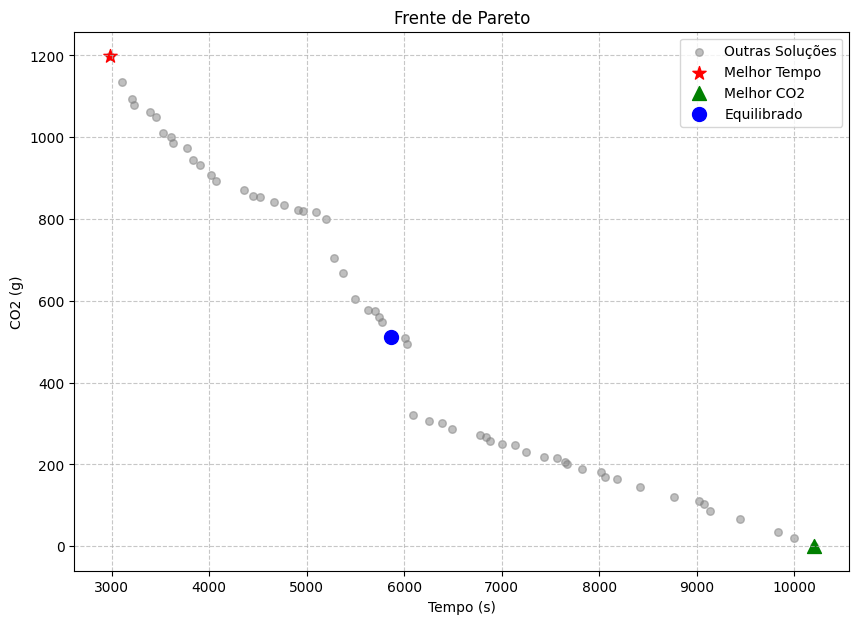

--------------------------------------------------
1. Melhor Tempo: 2978s | CO2: 1198.18g
2. Equilibrado : 5860s | CO2: 511.33g
3. Melhor CO2  : 10203s | CO2: 0.00g
--------------------------------------------------


In [24]:
F = res.F 
X = res.X 

# Analisar e Visualizar Resultados
idx_time = int(np.argmin(F[:, 0]))
idx_co2 = int(np.argmin(F[:, 1]))
sorted_indices = np.argsort(F[:, 0])
idx_balanced = int(sorted_indices[len(sorted_indices) // 2])

# Plotar a Frente de Pareto destacando os 3 pontos
plt.figure(figsize=(10, 7))
plt.scatter(F[:, 0], F[:, 1], c='gray', s=30, alpha=0.5, label='Outras Soluções')
plt.scatter(F[idx_time, 0], F[idx_time, 1], c='red', s=100, marker='*', label='Melhor Tempo')
plt.scatter(F[idx_co2, 0], F[idx_co2, 1], c='green', s=100, marker='^', label='Melhor CO2')
plt.scatter(F[idx_balanced, 0], F[idx_balanced, 1], c='blue', s=100, marker='o', label='Equilibrado')

plt.title("Frente de Pareto")
plt.xlabel("Tempo (s)")
plt.ylabel("CO2 (g)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# Imprimir detalhes
print("-" * 50)
print(f"1. Melhor Tempo: {F[idx_time, 0]:.0f}s | CO2: {F[idx_time, 1]:.2f}g")
print(f"2. Equilibrado : {F[idx_balanced, 0]:.0f}s | CO2: {F[idx_balanced, 1]:.2f}g")
print(f"3. Melhor CO2  : {F[idx_co2, 0]:.0f}s | CO2: {F[idx_co2, 1]:.2f}g")
print("-" * 50)

In [31]:
# 1. Configuração da Restrição de Tempo a Pé
MAX_WALK_MINUTES = 60  
max_walk_seconds = MAX_WALK_MINUTES * 60

# 2. Função de Avaliação (com tempo a pé)
# Velocidade média a pé (1.4 m/s ~= 5 km/h)
WALK_SPEED = 1.4 

def EvaluatePathDetailed(G, path):
    total_time = 0
    total_co2 = 0
    total_walk_dist = 0
    total_walk_time = 0
    
    for i in range(len(path) - 1):
        u, v = path[i], path[i+1]
        
        # Obter dados da aresta (compatível com MultiGraph)
        edge_data = G.get_edge_data(u, v)
        if edge_data is None: continue
        
        # Selecionar a primeira aresta disponível (caso existam múltiplas)
        if isinstance(edge_data, dict) and 0 in edge_data:
            data = edge_data[0]
        else:
            data = edge_data if not isinstance(edge_data, dict) else list(edge_data.values())[0]
        
        # --- CORREÇÃO AQUI ---
        mode = data.get('mode', 'walk') # Assume 'walk' se não tiver modo definido
        distance = data.get('length', data.get('distance', 0)) # Tenta 'length' (OSM) ou 'distance'
        
        # Calcular tempos
        if mode == 'walk' or mode == 'transfer_walk':
            # Se a aresta já tiver tempo definido, usa-o. 
            # Senão, calcula: Tempo = Distância / Velocidade
            if 'time' in data:
                seg_time = data['time']
            else:
                seg_time = distance / WALK_SPEED
            
            total_walk_dist += distance
            total_walk_time += seg_time
            total_time += seg_time
            
        else:
            # Transportes (Bus/Metro)
            # Aqui confiamos no atributo 'time' (que inclui espera + viagem)
            # Se for zero (erro no grafo), calculamos viagem mínima
            seg_time = data.get('time', 0)
            if seg_time == 0 and mode in ['bus', 'transit']:
                 # Fallback simples se o tempo vier a zero
                 seg_time = distance / 10.0 # Assumindo velocidade média bus/metro
            
            total_time += seg_time
            
        # CO2
        seg_co2 = data.get('co2', 0)
        total_co2 += seg_co2

    # Calorias (aprox 0.05 cal por metro a pé)
    calories = total_walk_dist * 0.05
    
    return {
        'time': total_time,
        'co2': total_co2,
        'calories': calories,
        'walk_time': total_walk_time # Agora deve vir correto
    }
# 3. Definição do Problema com Restrição de Tempo a Pé
class RoutingProblemTrimodal(ElementwiseProblem):
    def __init__(self, G, start_node, end_node, max_walk_sec, **kwargs):
        # n_obj=3 (Tempo, CO2, Calorias)
        # n_ieq_constr=1 (Restrição de tempo a pé)
        super().__init__(n_var=1, n_obj=3, n_ieq_constr=1, **kwargs)
        self.G = G
        self.start_node = start_node
        self.end_node = end_node
        self.max_walk_sec = max_walk_sec

    def _evaluate(self, x, out, *args, **kwargs):
        path = x[0]
        PENALTY = 1e6 
        
        # Verificações básicas de validade
        if path is None or len(path) == 0:
            out["F"] = [PENALTY, PENALTY, PENALTY]
            out["G"] = [PENALTY]
            return

        if path[0] != self.start_node or path[-1] != self.end_node:
            out["F"] = [PENALTY, PENALTY, PENALTY]
            out["G"] = [PENALTY]
            return

        try:
            stats = EvaluatePathDetailed(self.G, path)
            
            # Objetivos:
            # 1. Minimizar Tempo
            # 2. Minimizar CO2
            # 3. Maximizar Calorias (Minimizar -Calorias)
            f1 = float(stats['time'])
            f2 = float(stats['co2'])
            f3 = -float(stats['calories']) 
            
            out["F"] = [f1, f2, f3]
            
            # Restrição (Constraints):
            # g1 <= 0  ->  (Tempo a pé - Limite) <= 0
            g1 = stats['walk_time'] - self.max_walk_sec
            out["G"] = [g1]
            
        except Exception as e:
            out["F"] = [PENALTY, PENALTY, PENALTY]
            out["G"] = [PENALTY]

# 4. Configuração e Execução do Algoritmo

# Instanciar o novo problema
problem_trimodal = RoutingProblemTrimodal(G_Multi, source_node, target_node, max_walk_seconds)

# Direções de Referência para 3 Objetivos
# n_partitions=12 para 3 objs gera ~91 pontos, próximo de 100
ref_dirs_3obj = get_reference_directions("das-dennis", 3, n_partitions=12)
pop_size_3obj = ref_dirs_3obj.shape[0]

# Configurar Algoritmo
algorithm = NSGA3(
    pop_size=pop_size_3obj, # Ajusta-se automaticamente (aprox 91 ou 100)
    ref_dirs=ref_dirs_3obj,
    sampling=DynamicGraphSampling(
        G_Multi, 
        source_node, 
        target_node, 
        start_datetime, 
        active_bus_ids, 
        active_transit_ids
    ),
    crossover=PathCrossover(prob=0.8),
    mutation=PathMutation(G_Multi, prob=0.3),
    eliminate_duplicates=PathDuplicateElimination()
)

print(f"🚀 A iniciar Otimização: 3 Objetivos (Inc. Exercício) + Max {MAX_WALK_MINUTES}min a pé...")
res = minimize(
    problem_trimodal,
    algorithm,
    ('n_gen', 50),
    seed=1,
    verbose=True
)

🚀 A iniciar Otimização: 3 Objetivos (Inc. Exercício) + Max 60min a pé...
🔄 A gerar 91 caminhos iniciais DINÂMICOS (consultando horários)...
✅ Inicialização Dinâmica concluída. 1 caminhos únicos gerados.
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        1 |      1 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |       90 |     13 |  0.000000E+00 |  2.590125E+03 |  1.0000000000 |         ideal
     3 |      181 |     21 |  0.000000E+00 |  4.804750E+02 |  0.2643747791 |         ideal
     4 |      272 |     25 |  0.000000E+00 |  9.2706516455 |  0.1841249917 |         ideal
     5 |      363 |     30 |  0.000000E+00 |  0.000000E+00 |  0.1102615753 |         ideal
     6 |      454 |     31 |  0.000000E+00 |  0.000000E+00 |  0.0111001300 |             f
     7 |      545 |     33 |  0.000000E+00 |  0.000000E+00 |  0.0073527164 |             f
     8 |      636 |     34 |  0.000000E+00 |  0.000000E+00 |  0.01501

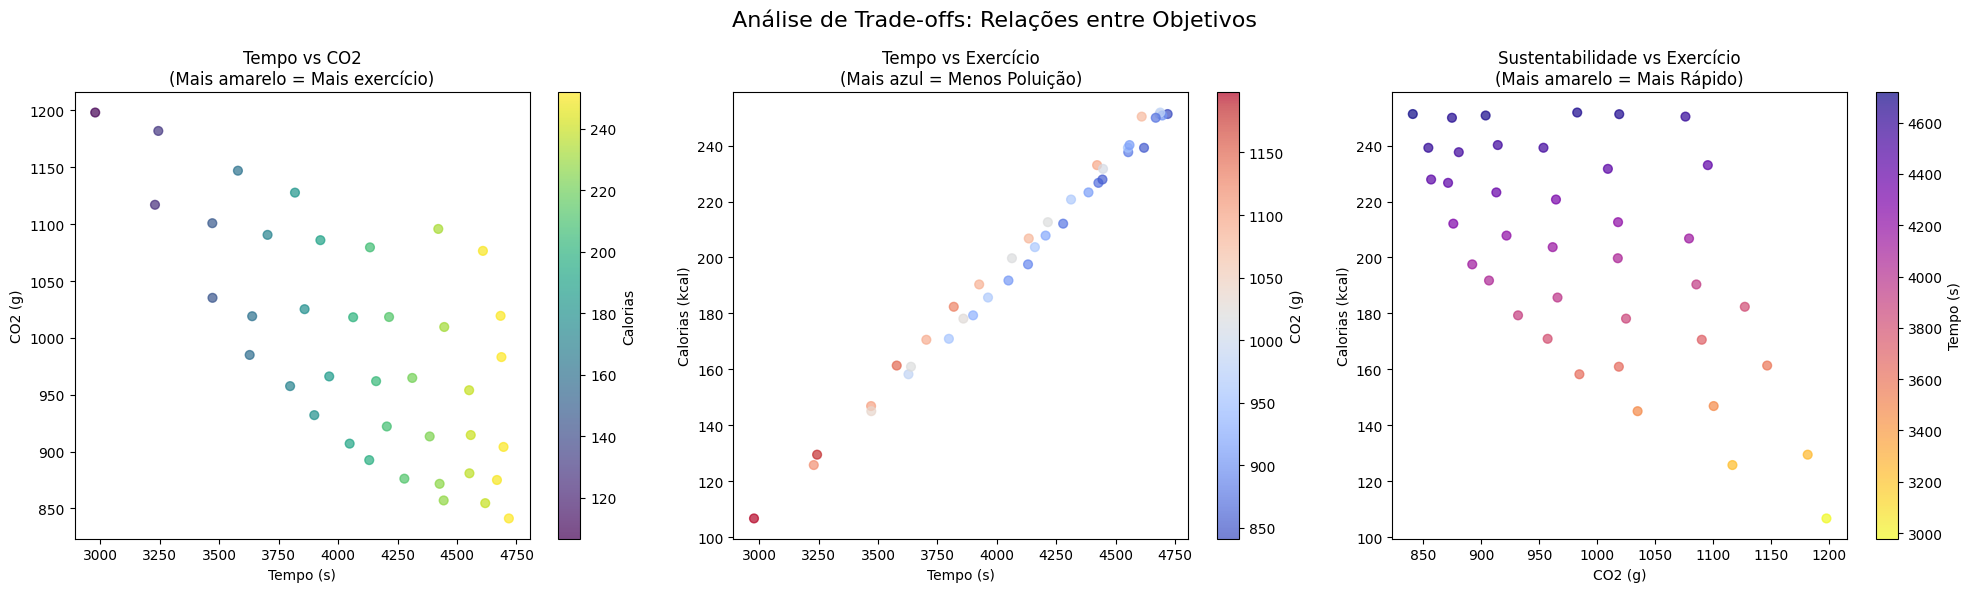

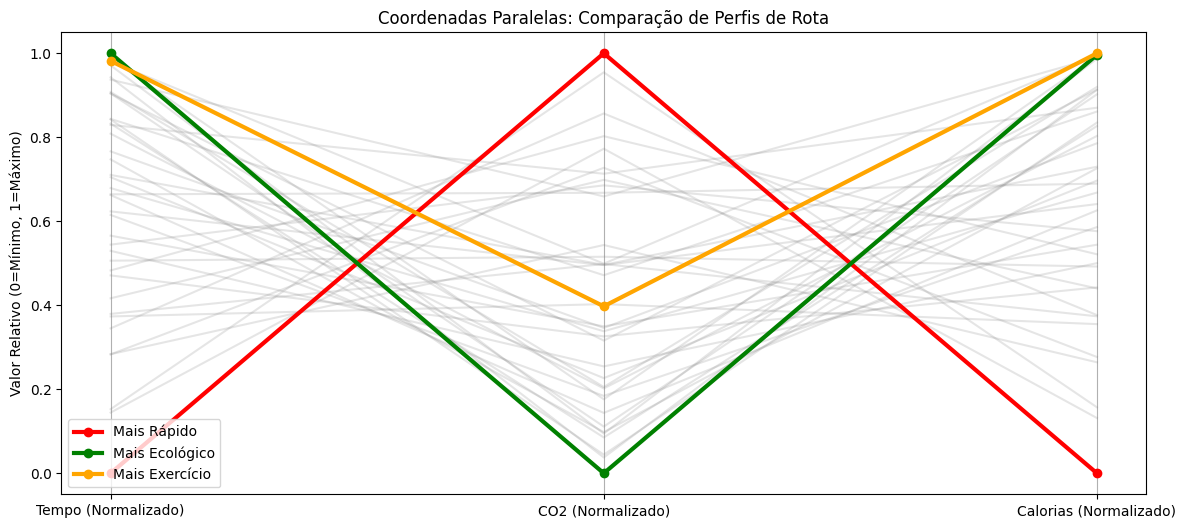

Melhores Soluções Encontradas:
Rapidez:   2978s (Andas 2135m)
Ecologia:  841.2g CO2 (Andas 5025m)
Fitness:   252 kcal (Andas 5036m)


In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Verificar se existem resultados
if res.X is not None:
    F = res.F
    
    # 1. Preparar Dados
    Time = F[:, 0]
    CO2 = F[:, 1]
    Calories = -F[:, 2] # Converter para positivo
    
    # Identificar os melhores de cada categoria
    idx_best_time = np.argmin(Time)
    idx_best_co2 = np.argmin(CO2)
    idx_best_cal = np.argmax(Calories)
    
    # Vizualizações

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    plt.suptitle("Análise de Trade-offs: Relações entre Objetivos", fontsize=16)

    # Gráfico A: Tempo vs CO2 (Cor = Calorias)
    sc1 = axes[0].scatter(Time, CO2, c=Calories, cmap='viridis', s=40, alpha=0.7)
    axes[0].set_xlabel('Tempo (s)')
    axes[0].set_ylabel('CO2 (g)')
    axes[0].set_title('Tempo vs CO2\n(Mais amarelo = Mais exercício)')
    plt.colorbar(sc1, ax=axes[0], label='Calorias')

    # Gráfico B: Tempo vs Calorias (Cor = CO2)
    sc2 = axes[1].scatter(Time, Calories, c=CO2, cmap='coolwarm', s=40, alpha=0.7)
    axes[1].set_xlabel('Tempo (s)')
    axes[1].set_ylabel('Calorias (kcal)')
    axes[1].set_title('Tempo vs Exercício\n(Mais azul = Menos Poluição)')
    plt.colorbar(sc2, ax=axes[1], label='CO2 (g)')

    # Gráfico C: CO2 vs Calorias (Cor = Tempo)
    sc3 = axes[2].scatter(CO2, Calories, c=Time, cmap='plasma_r', s=40, alpha=0.7) # plasma_r invetido para amarelo ser bom (rápido)
    axes[2].set_xlabel('CO2 (g)')
    axes[2].set_ylabel('Calorias (kcal)')
    axes[2].set_title('Sustentabilidade vs Exercício\n(Mais amarelo = Mais Rápido)')
    plt.colorbar(sc3, ax=axes[2], label='Tempo (s)')

    plt.tight_layout()
    plt.show()

    # Gráfico de Coordenadas Paralelas

    plt.figure(figsize=(14, 6))
    
    # Normalizar dados (Min-Max Scaling) para caberem na mesma escala 0-1
    def normalize(v):
        return (v - np.min(v)) / (np.max(v) - np.min(v))

    norm_time = normalize(Time)
    norm_co2 = normalize(CO2)
    norm_cal = normalize(Calories) # 1 é o máximo de calorias

    for i in range(len(Time)):
        plt.plot([0, 1, 2], [norm_time[i], norm_co2[i], norm_cal[i]], color='gray', alpha=0.2)

    # Rápido
    plt.plot([0, 1, 2], [norm_time[idx_best_time], norm_co2[idx_best_time], norm_cal[idx_best_time]], 
             color='red', linewidth=3, marker='o', label='Mais Rápido')
    
    # Ecológico
    plt.plot([0, 1, 2], [norm_time[idx_best_co2], norm_co2[idx_best_co2], norm_cal[idx_best_co2]], 
             color='green', linewidth=3, marker='o', label='Mais Ecológico')

    # Fitness
    plt.plot([0, 1, 2], [norm_time[idx_best_cal], norm_co2[idx_best_cal], norm_cal[idx_best_cal]], 
             color='orange', linewidth=3, marker='o', label='Mais Exercício')

    plt.xticks([0, 1, 2], ['Tempo (Normalizado)', 'CO2 (Normalizado)', 'Calorias (Normalizado)'])
    plt.ylabel('Valor Relativo (0=Mínimo, 1=Máximo)')
    plt.title('Coordenadas Paralelas: Comparação de Perfis de Rota')
    plt.legend()
    plt.grid(True, axis='x')
    plt.show()

    print("Melhores Soluções Encontradas:")
    print(f"Rapidez:   {Time[idx_best_time]:.0f}s (Andas {Calories[idx_best_time]/0.05:.0f}m)")
    print(f"Ecologia:  {CO2[idx_best_co2]:.1f}g CO2 (Andas {Calories[idx_best_co2]/0.05:.0f}m)")
    print(f"Fitness:   {Calories[idx_best_cal]:.0f} kcal (Andas {Calories[idx_best_cal]/0.05:.0f}m)")

else:
    print("Sem resultados.")